# Travel Insurance Prediction Analysis

## 1. Goal of the analysis

### 1.1 The goal:

- Predict travel insurance purchase likelihood based on customer data, ensuring a balance between identifying potential buyers and reducing misclassification errors.
- Identify key factors for purchasing insurance.

Stakeholders:
- **Insurance companies** (maximize revenue by targeting real potential buyers).
- **Marketing teams** (optimize ad spending by reducing wasted targeting).
- **Business analysts** (improve risk assessment for travel insurance policies)

Chosen Metric: **Precision-Recall AUC (AP Score)**

Recall was initially prioritized to capture all potential customers, but a high recall alone led to many false positives, meaning customers unlikely to buy were incorrectly predicted as buyers.
After reiteration, Precision-Recall AUC was chosen, which balances precision and recall, providing a more reliable measure of how well the model distinguishes actual buyers.

### 1.2 Context and description:

The dataset contains records of customers from a tour & travel company, which offers a travel insurance package, including COVID coverage. The company aims to determine which customers are likely to purchase insurance based on their past data.

The dataset, sourced from Kaggle ([link](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data)), consists of approximately 2000 customers. It includes demographic and financial attributes that may influence the decision to purchase travel insurance. The dataset was collected in 2019, based on the performance and sales of the package during that period.

- **Age** - Age of the customer.
- **Employment Type** - The sector in which the customer is employed (**Government Sector** or **Private Sector/Self Employed**)
- **GraduateOrNot** - Whether the customer is a college graduate or not
- **AnnualIncome** - The yearly income of the customer in Indian Rupees (rounded to nearest 50 thousand Rupees)
- **FamilyMembers** - Number of members in customer's family
- **ChronicDisease** - Whether the customer suffers from any major disease or conditions like diabetes/high BP or asthama, etc.
- **FrequentFlyer** - Derived data based on customer's history of booking air tickets on atleast 4 different instances in the years 2017-2019.
- **EverTravelledAbroad** - Has the customer ever travelled to a foreign country (not necessarily using the company's services)
- **TravelInsurance** - Did the customer buy travel insurance package during introductory offering held in the year 2019.

### 1.3 Main points:

- **Data Quality**: Examine the dataset for missing values, duplicates, and outliers to ensure reliability before analysis.
- **Feature Relationships & Correlations**: Investigate the relationships between independent variables and travel insurance purchase, identifying key drivers.
- **Class Imbalance**: The dataset exhibited an imbalance in the target variable, which was addressed in model training.
- **Statistical Testing**: Hypothesis tests were conducted to assess the significance of various predictors, including chi-square tests for categorical features and t-tests for numerical ones.
- **Modeling Approach**: Testing multiple machine learning models, including logistic regression, decision trees, random forest, and SVM, evaluating their performance.
- **Model Performance**: Assess models using PR-AUC to determine the best predictive approach.

### 1.4 First, the libraries are imported and a consistent visual colormap for the analysis is created.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import (ttest_ind, sem, t, chi2_contingency, ttest_ind)
from statsmodels.stats.proportion import (proportions_ztest,
                                          proportion_confint,
                                          confint_proportions_2indep)
from sklearn.preprocessing import (PolynomialFeatures,
                                   StandardScaler)
from sklearn.model_selection import (train_test_split,
                                     cross_val_predict,
                                     StratifiedKFold)
from sklearn.metrics import (make_scorer,
                             average_precision_score,
                             classification_report)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from utilities import (
    find_missing_values,
    find_outliers,
    plot_corr_matrix,
    check_vif,
    model_performance_comparison,
    create_poly_features,
    plot_insured_previously_traveled,
    model_hyperparameter_tuning,
    plot_confusion_matrix,
    plot_feature_importances,
    make_dummy_classifier,
    plot_income_insurance_status,
    plot_original_duplicate_distributions
)

In [2]:
pd.set_option("display.max_colwidth", None)
plt.rcParams["figure.figsize"] = (10, 6)
colors = ["#92c5de", "#ca0020", "#f4a582", "#0571b0"]
sns.set_theme(style="white")
sns.set_palette(sns.color_palette(colors))
pd.set_option("future.no_silent_downcasting", True)

## 2. Cleaning and inspecting the data

### 2.1 Importing the dataset and taking a look at it

In [3]:
df = pd.read_csv("TravelInsurancePrediction.csv", index_col="Unnamed: 0")
df

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0
...,...,...,...,...,...,...,...,...,...
1982,33,Private Sector/Self Employed,Yes,1500000,4,0,Yes,Yes,1
1983,28,Private Sector/Self Employed,Yes,1750000,5,1,No,Yes,0
1984,28,Private Sector/Self Employed,Yes,1150000,6,1,No,No,0
1985,34,Private Sector/Self Employed,Yes,1000000,6,0,Yes,Yes,1


There seem to be 1987 entries with 9 features each.

### 2.2 Renaming features to binary format

In [4]:
features_to_binary = ["GraduateOrNot","FrequentFlyer","EverTravelledAbroad"]
df[features_to_binary] = df[features_to_binary].replace({"Yes":1,"No":0})
df["Employment Type"] = df["Employment Type"].replace({"Government Sector":0,
                                                       "Private Sector/Self Employed": 1})
df = df.infer_objects()
df

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,0,1,400000,6,1,0,0,0
1,31,1,1,1250000,7,0,0,0,0
2,34,1,1,500000,4,1,0,0,1
3,28,1,1,700000,3,1,0,0,0
4,28,1,1,700000,8,1,1,0,0
...,...,...,...,...,...,...,...,...,...
1982,33,1,1,1500000,4,0,1,1,1
1983,28,1,1,1750000,5,1,0,1,0
1984,28,1,1,1150000,6,1,0,0,0
1985,34,1,1,1000000,6,0,1,1,1


### 2.3 Checking for missing values

In [5]:
find_missing_values(df)

,Zeroes,Empty Strings,NaN
Age,0,0,0
Employment Type,570,0,0
GraduateOrNot,295,0,0
AnnualIncome,0,0,0
FamilyMembers,0,0,0
ChronicDiseases,1435,0,0
FrequentFlyer,1570,0,0
EverTravelledAbroad,1607,0,0
TravelInsurance,1277,0,0


There are 0's in binary fields (0/1), where 0's indicate "No" answers (or "Government Sector" in the Employment Type field).

### 2.4 Checking for duplicates

In [6]:
duplicates = df[df.duplicated()]
print(f"There are {len(duplicates)} duplicated rows.")

There are 738 duplicated rows.


There seem to be a lot of duplicates - nearly a third of the dataset. This will need further inspection.

### 2.5 Checking whether the presence of duplicates is independent of `TravelInsurance` value using **chi2 contingency** test.

In [7]:
contingency_table = pd.crosstab(df["TravelInsurance"], df.duplicated())

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test p-value: {p:.3F}")

contingency_table_norm = contingency_table.div(contingency_table.sum(axis=0), axis=1)
contingency_table_norm.columns = ["Unique", "Duplicate"]
contingency_table_norm

Chi-square test p-value: 0.000


,Unique,Duplicate
TravelInsurance,,
0,0.613291,0.692412
1,0.386709,0.307588


The test shows whether there is a significant relationship between having duplicate rows and buying travel insurance.

With a very low **p-value**, this suggests that there is a statistically significant relationship between duplicate status and buying insurance. In other words, the proportion of people buying insurance differs between unique and duplicate rows (we can see that by ~38.7% people buying insurance in unique rows, while in duplicate rows only ~30.8% people buy insurance).

### 2.6 Checking the feature distribution between original and duplicate data

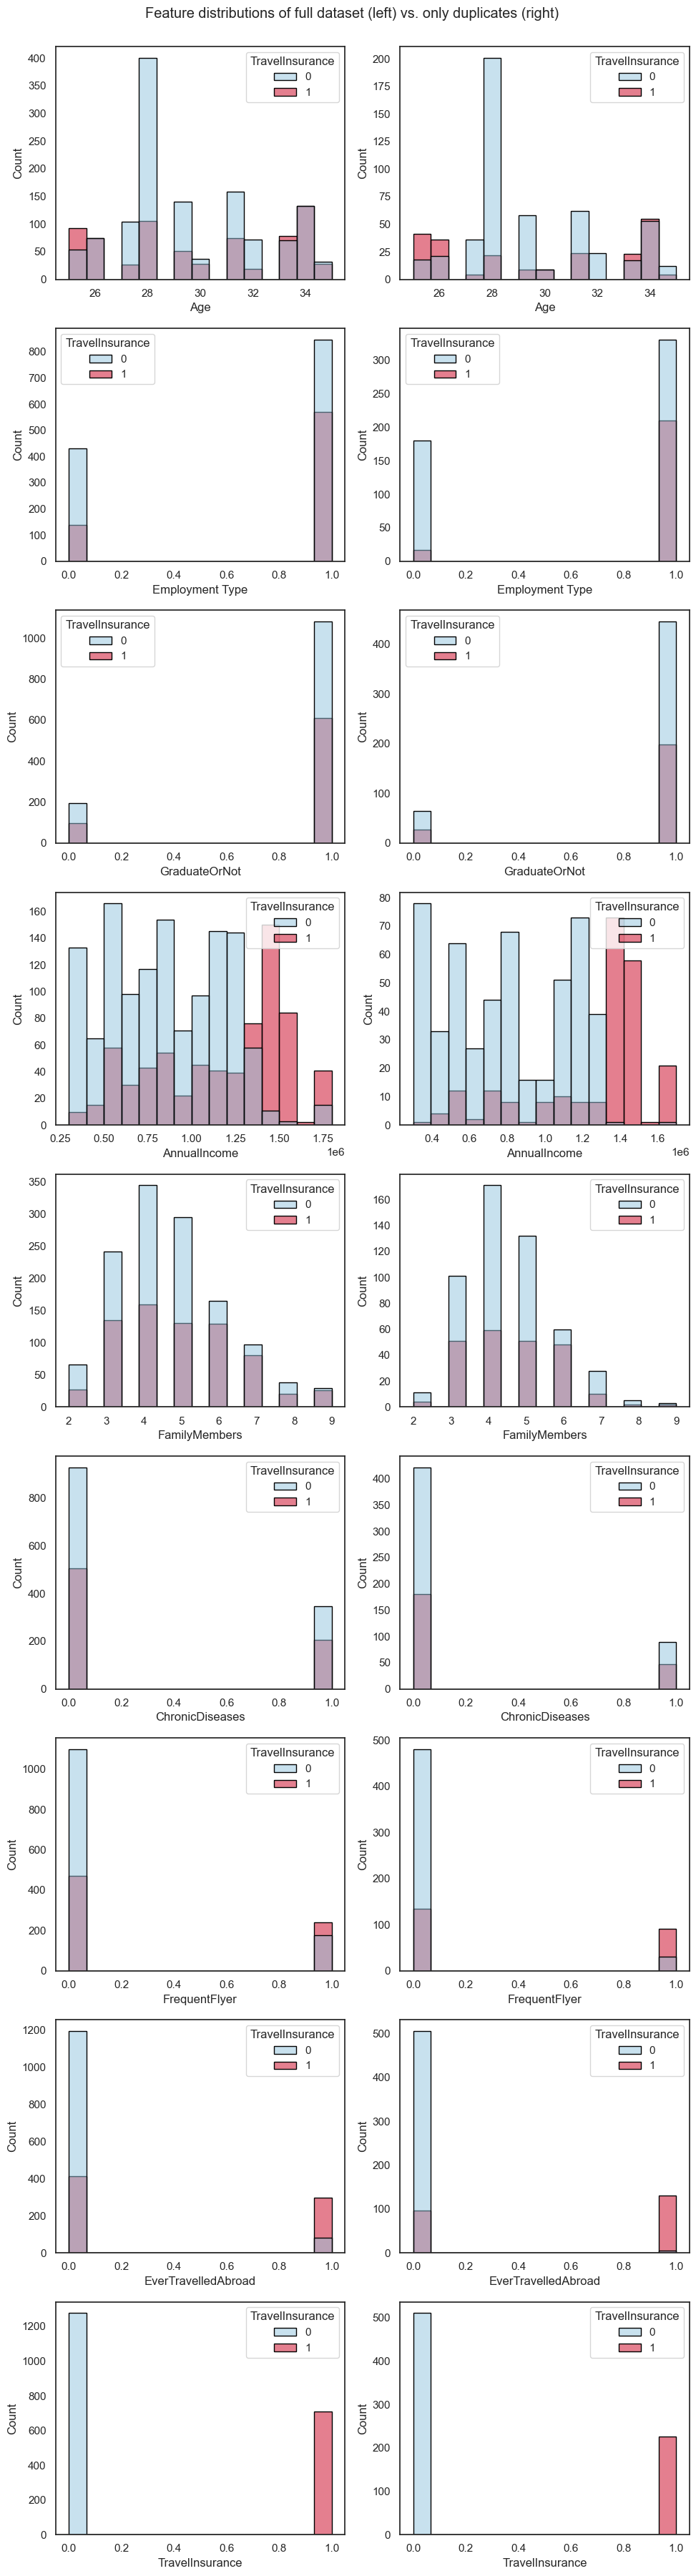

In [8]:
plot_original_duplicate_distributions(df, duplicates)

It seems like the distribution for features and corresponding labels is nearly identical for duplicate and original data. However, as seen with the previous test, the duplicate data has slightly less occurences of purchased travel insurance labels (1's). These duplicates seem like they can be natural occurences. However, there is not enough information on how the data was acquired.

To avoid model overfitting, as well as provide more accurate information to the models (e.g. different people with **same characteristics (columns)** can have **different "labels" (purchased insurance or not)**), indentical duplicates will be removed while only keeping 1 sample of each.

In [9]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1249 entries, 0 to 1985
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Age                  1249 non-null   int64
 1   Employment Type      1249 non-null   int64
 2   GraduateOrNot        1249 non-null   int64
 3   AnnualIncome         1249 non-null   int64
 4   FamilyMembers        1249 non-null   int64
 5   ChronicDiseases      1249 non-null   int64
 6   FrequentFlyer        1249 non-null   int64
 7   EverTravelledAbroad  1249 non-null   int64
 8   TravelInsurance      1249 non-null   int64
dtypes: int64(9)
memory usage: 97.6 KB


### 2.7 Checking for outliers

In [10]:
numeric = [feature for feature in df if df[feature].dtype in ["int64", "float64"]]
outliers = find_outliers(df, numeric)
outliers

**Feature-wise Outlier Analysis**

,Feature Name,Outliers,Percentage,IQR Bounds,Flagged Values
2,GraduateOrNot,202,16.17%,"[1.00, 1.00]","[0.00, 0.00]"
6,FrequentFlyer,295,23.62%,"[0.00, 0.00]","[1.00, 1.00]"
7,EverTravelledAbroad,244,19.54%,"[0.00, 0.00]","[1.00, 1.00]"


**All Outliers**

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
4,28,1,1,700000,8,1,1,0,0
5,25,1,0,1150000,4,0,0,0,0
7,31,1,1,1350000,3,0,1,1,1
8,28,1,1,1450000,6,1,1,1,1
9,33,0,1,800000,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1974,28,1,1,1200000,6,0,1,0,0
1975,26,1,1,1400000,9,0,0,1,1
1982,33,1,1,1500000,4,0,1,1,1
1983,28,1,1,1750000,5,1,0,1,0


In [11]:
df.describe()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
count,1249.000000,1249.000000,1249.000000,1.249000e+03,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000
mean,29.755805,0.701361,0.838271,9.345476e+05,4.890312,0.333066,0.236189,0.195356,0.386709
std,2.921039,0.457844,0.368350,3.607293e+05,1.762313,0.471499,0.424910,0.396634,0.487191
min,25.000000,0.000000,0.000000,3.000000e+05,2.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,1.000000,6.000000e+05,4.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,1.000000,1.000000,9.000000e+05,5.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,1.000000,1.000000,1.200000e+06,6.000000,1.000000,0.000000,0.000000,1.000000
max,35.000000,1.000000,1.000000,1.800000e+06,9.000000,1.000000,1.000000,1.000000,1.000000


There's only outliers in the binary fields, which is fine since it just indicates that some features have more 1's or 0's.

### 2.8 Checking the correlations between features

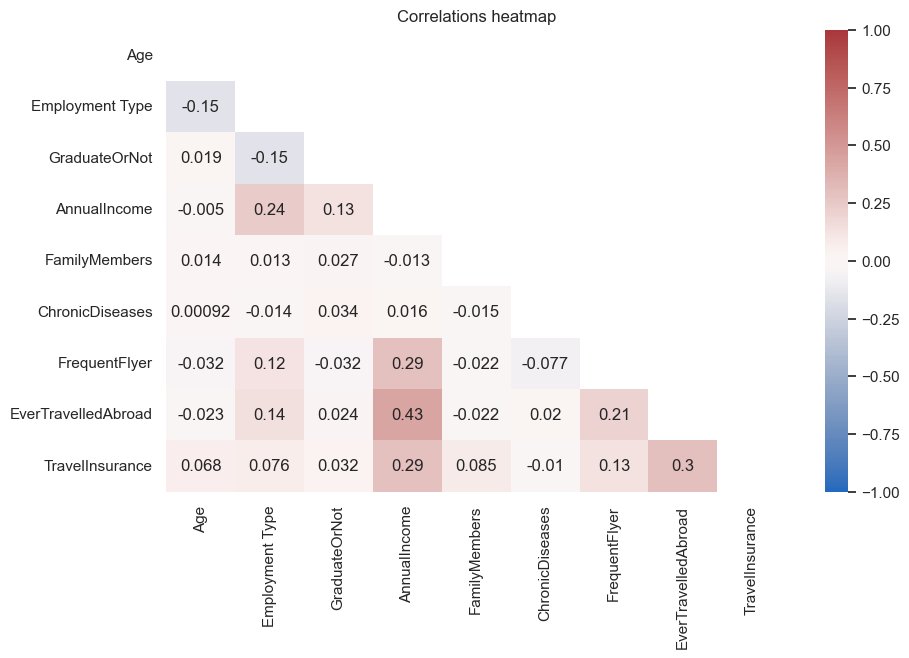

In [12]:
plot_corr_matrix(df[numeric])

**Correlations of interest:**
- *Travel Insurance* and *Annual Income* (0.29)
- *Travel Insurance* and *Ever Travelled Abroad* (0.3)

## 3. Statistical inference

### 3.1 Based on the findings, this is the first hypothesis:

**H0 (Null Hypothesis)**: Having ever travelled abroad has no impact on purchasing travel insurance.

**Ha (Alternative Hypothesis)**: Having ever travelled abroad **increases** the chance of purchasing travel insurance.

**α = 0.05 (5%)**

#### Since the sample sizes are large, the proportions z-test is efficient because it assumes normality based on the Central Limit Theorem.

#### Assumptions:

- Data independence: due to the nature of the dataset, each customer does not affect each other's data travel insurance purchases.
- Binary outcome: data has only 2 outcomes (True/False)
- Simple random samples - met due the nature of our dataset
- Large enough sample size (at least 5 observations of True and False in each group)


In [13]:
n_travelled = df[df["EverTravelledAbroad"] == 1].shape[0]
n_not_travelled = df[df["EverTravelledAbroad"] == 0].shape[0]

n_travelled_insured = df[(df["EverTravelledAbroad"] == 1) &
                         (df["TravelInsurance"] == 1)].shape[0]
n_not_travelled_insured = df[(df["EverTravelledAbroad"] == 0) &
                             (df["TravelInsurance"] == 1)].shape[0]

counts = [n_travelled_insured, n_not_travelled_insured]
nobs = [n_travelled, n_not_travelled]

z_stat, p_value = proportions_ztest(counts, nobs, alternative="larger")
print(f"Z-statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

Z-statistic: 10.6456, p-value: 0.0000


With a one-sided proportions z-test, a **p-value of below alpha 0.05** is obtained, meaning the **null hypothesis is rejected** - having ever travelled abroad increases the chance of purchasing travel insurance.

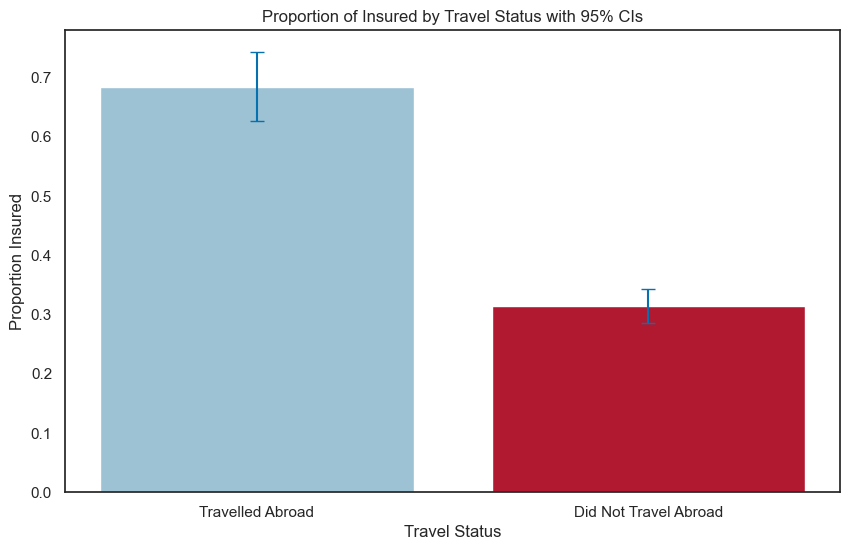

Proportion of previously travelled and insured: 68.44%, with a 95% confidence interval of 62.61% - 74.27%
Proportion of previously not travelled and insured: 31.44%, with a 95% confidence interval of 28.57% - 34.31%


In [14]:
prop_travelled_insured = n_travelled_insured / n_travelled
prop_not_travelled_insured = n_not_travelled_insured / n_not_travelled

conf_int_travelled = proportion_confint(n_travelled_insured,
                                        n_travelled, 0.05)
conf_int_not_travelled = proportion_confint(n_not_travelled_insured,
                                            n_not_travelled, 0.05)

plot_insured_previously_traveled(conf_int_travelled, conf_int_not_travelled,
                                 prop_travelled_insured, prop_not_travelled_insured)

print(f"Proportion of previously travelled and insured: "
      f"{prop_travelled_insured*100:.2f}%, with a 95% confidence interval of "
      f"{conf_int_travelled[0]*100:.2f}% - {conf_int_travelled[1]*100:.2f}%")

print(f"Proportion of previously not travelled and insured: "
      f"{prop_not_travelled_insured*100:.2f}%, with a 95% confidence interval of "
      f"{conf_int_not_travelled[0]*100:.2f}% - {conf_int_not_travelled[1]*100:.2f}%")

In [15]:
ci_low, ci_high = confint_proportions_2indep(
    count1=n_travelled_insured, nobs1=n_travelled,
    count2=n_not_travelled_insured, nobs2=n_not_travelled
)

print(f"95% Confidence interval for difference in insurance purchase rates: "
      f"({ci_low*100:.2f}, {ci_high*100:.2f})\n")

95% Confidence interval for difference in insurance purchase rates: (30.25, 43.18)



Based on 95% confidence interval results, people that have previously traveled abroad are 30.25% - 43.18% more likely to purchase insurance over people that have not previously traveled abroad.

### 3.2 Hypothesis #2:

**H0 (Null Hypothesis)**: Having a higher annual income has no impact on purchasing travel insurance.

**Ha (Alternative Hypothesis)**: Having a higher annual income **increases** the chance of purchasing travel insurance.

**α = 0.05 (5%)**

To compare continuous numerical data (income) and binary data (travel insurance purchase), a t-test will be used. Specifically, Welch's t-test will be used, as the population variances are not equal as seen in previous plots.

Assumptions for this test are:
- Data normality - as seen in plots the data does not follow normal distribution, but Central Limit Theorem bypasses this need with a large enough sample size
- Independent observations
- Data should be continuous
- No significant outliers in both groups

In [16]:
income_insured = df[df["TravelInsurance"] == 1]["AnnualIncome"]
income_not_insured = df[df["TravelInsurance"] == 0]["AnnualIncome"]

t_stat, p_value = ttest_ind(income_insured, income_not_insured,
                            equal_var=False, alternative="greater")
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

T-statistic: 10.5275, p-value: 0.0000


With a one-sided Welch's t-test, a **p-value of below alpha 0.05** is obtained, meaning the **null hypothesis is rejected** - having a higher annual income increases the chance of purchasing travel insurance.

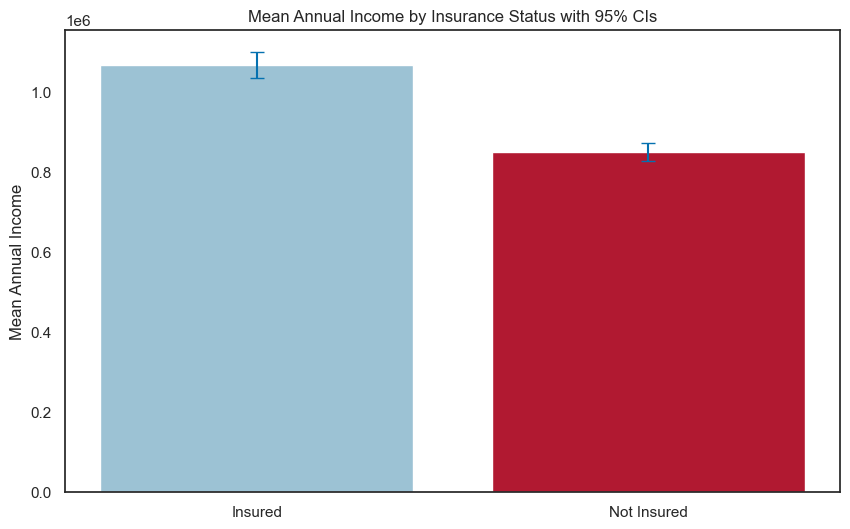

Mean annual income (insured): 1068012.42, 95% CI: (1034614.78, 1101410.07)
Mean annual income (not insured): 850391.64, 95% CI: (827296.14, 873487.15)


In [17]:
mean_insured = income_insured.mean()
mean_not_insured = income_not_insured.mean()

ci_insured = t.interval(0.95, df=len(income_insured)-1,
                        loc=mean_insured, scale=sem(income_insured))

ci_not_insured = t.interval(0.95, df=len(income_not_insured)-1,
                            loc=mean_not_insured, scale=sem(income_not_insured))

plot_income_insurance_status(mean_insured, mean_not_insured,
                             ci_insured, ci_not_insured)

print(f"Mean annual income (insured): {mean_insured:.2f}, "
      f"95% CI: ({ci_insured[0]:.2f}, {ci_insured[1]:.2f})")
print(f"Mean annual income (not insured): {mean_not_insured:.2f}, "
      f"95% CI: ({ci_not_insured[0]:.2f}, {ci_not_insured[1]:.2f})")

In [18]:
mean_diff = mean_insured - mean_not_insured

se_diff = np.sqrt(sem(income_insured)**2 + sem(income_not_insured)**2)
ci_diff = t.interval(0.95, df=len(income_insured) + len(income_not_insured) - 2, 
                           loc=mean_diff, scale=se_diff)

print(f"95% Confidence Interval for difference in means: "
      f"({ci_diff[0]:.2f}, {ci_diff[1]:.2f})\n")

95% Confidence Interval for difference in means: (177065.69, 258175.87)



Based on 95% confidence interval results, people that purchase insurance have ~177k - ~285k higher annual income in Indian Rupees over people that don't purchase the travel insurance

## 4. Modelling

### 4.1 Checking for multicollinearity using VIF (variance inflation factor)

In [19]:
check_vif(df, "TravelInsurance")

,Feature,VIF
0,Age,1.03
1,Employment Type,1.13
2,GraduateOrNot,1.06
3,AnnualIncome,1.39
4,FamilyMembers,1.00
5,ChronicDiseases,1.01
6,FrequentFlyer,1.12
7,EverTravelledAbroad,1.24


All of the VIF values are in norm (<5), indicating that these features do not have correlation with other independent features. Therefore, there is nothing to do here now.

### 4.2 Splitting the data and performing sanity check

In [20]:
X = df.drop(columns=["TravelInsurance"])
y = df["TravelInsurance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

The data was split to 80% train and 20% test set, stratifying on the target variable (*TravelInsurance*).

In [21]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}\n")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}\n")

print(f"Train ratio: {len(X_train) / len(X) :.2%}, Test ratio: "
      f"{len(X_test) / len(X) :.2%}")

X_train shape: (999, 8)
y_train shape: (999,)

X_test shape: (250, 8)
y_test shape: (250,)

Train ratio: 79.98%, Test ratio: 20.02%


As expected, the ratio is 80%-20%, with 999 samples in the train set and 250 samples in the test set.

In [22]:
print("Class distribution in full dataset:")
print(y.value_counts(normalize=True))

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Class distribution in full dataset:
TravelInsurance
0    0.613291
1    0.386709
Name: proportion, dtype: float64

Class distribution in training set:
TravelInsurance
0    0.613614
1    0.386386
Name: proportion, dtype: float64

Class distribution in test set:
TravelInsurance
0    0.612
1    0.388
Name: proportion, dtype: float64


The class distribution seems to be near identical in full, training and test sets, which means the data was stratified correctly during splitting.

In [23]:
overlap = set(X_train.index) & set(X_test.index)
print(f"Number of overlapping indices: {len(overlap)}")

Number of overlapping indices: 0


No overlapping indices indicate the train and test splits have unique rows from the original dataset.

### 4.3 Baseline model

In [24]:
make_dummy_classifier("most_frequent", X_train, y_train, X_test, y_test)
make_dummy_classifier("stratified", X_train, y_train, X_test, y_test)


most_frequent Precision: 0.0
most_frequent Recall: 0.0
most_frequent PR AUC: 0.388

stratified Precision: 0.4227
stratified Recall: 0.4227
stratified PR AUC: 0.4027


- Since the dataset is imbalanced (more occurences of people that did not buy the insurance), using the most-frequent strategy has a precision and recall of 0, since it never predicts the minority class. Even though it never predicts the positive class, the probability outputs still reflect class imbalance, giving a nonzero PR AUC.

- Since the stratified strategy makes random guesses based on class proportions, a slightly higher PR AUC score of **~0.4027** is obtained, which can be used to compare with further models.

### 4.4 Model comparison

To pick the best 3 models that will be tuned further, a performance of these models is compared for the target metric:
- Logistic Regression
- SVM (Support Vector Machine)
- KNN (K-Nearest Neighbors)
- Random Forest
- Decision Tree

The first 3 models require their data to be scaled, therefore they will be ran through a pipeline with a Standard Scaler first.

In [25]:
scaling_required_models = {
    "Logistic Regression": LogisticRegression(random_state=42,
                                              class_weight="balanced",
                                              max_iter=1000),
    "SVM": SVC(probability=True, class_weight="balanced"),
    "KNN": KNeighborsClassifier()
}

no_scaling_models = {
    "Random Forest": RandomForestClassifier(random_state=42,
                                            class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(random_state=42,
                                            class_weight="balanced")
}

In [26]:
scorer = make_scorer(average_precision_score, response_method="predict_proba")
scaler = StandardScaler()
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_performance_comparison(scaling_required_models, no_scaling_models, scaler,
                             X_train, y_train,
                             stratified_kfold, scorer
                             )

Logistic Regression Mean PR AUC: 0.6296
SVM Mean PR AUC: 0.6882
KNN Mean PR AUC: 0.5802
Random Forest Mean PR AUC: 0.6256
Decision Tree Mean PR AUC: 0.4322


Due to class imbalance, a Stratified K-Fold cross-validator was used, as well as balanced class weight for models that support it.

The best PR AUC scores are obtained using **SVM** (*PR AUC score of **0.6882***), **Random Forest** (*PR AUC score of **0.6256***) and **Logistic Regression** (*PR AUC score of **0.6296***) models. These will be the models that will be used for further hyperparameter tuning to find the best final model. Additionally, all models seemed to perform better than the random Dummy Classifier model.

In [27]:
del scaling_required_models["KNN"]
del no_scaling_models["Decision Tree"]

### 4.5 Feature engineering

Polynomial features with only interaction terms are generated and added to a new training dataframe:

In [28]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = create_poly_features(X_train, poly)
X_train_poly

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,Age Employment Type,Age GraduateOrNot,...,AnnualIncome FamilyMembers,AnnualIncome ChronicDiseases,AnnualIncome FrequentFlyer,AnnualIncome EverTravelledAbroad,FamilyMembers ChronicDiseases,FamilyMembers FrequentFlyer,FamilyMembers EverTravelledAbroad,ChronicDiseases FrequentFlyer,ChronicDiseases EverTravelledAbroad,FrequentFlyer EverTravelledAbroad
452,34.0,1.0,1.0,1300000.0,4.0,1.0,0.0,0.0,34.0,34.0,...,5200000.0,1300000.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
471,26.0,1.0,1.0,1250000.0,3.0,0.0,0.0,0.0,26.0,26.0,...,3750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1837,34.0,1.0,1.0,1300000.0,5.0,0.0,0.0,1.0,34.0,34.0,...,6500000.0,0.0,0.0,1300000.0,0.0,0.0,5.0,0.0,0.0,0.0
1942,28.0,1.0,1.0,900000.0,5.0,0.0,0.0,0.0,28.0,28.0,...,4500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
693,27.0,1.0,0.0,800000.0,5.0,1.0,0.0,0.0,27.0,0.0,...,4000000.0,800000.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,33.0,0.0,1.0,650000.0,6.0,1.0,0.0,0.0,0.0,33.0,...,3900000.0,650000.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
613,31.0,1.0,1.0,1250000.0,6.0,0.0,0.0,0.0,31.0,31.0,...,7500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
371,27.0,0.0,1.0,900000.0,5.0,1.0,0.0,1.0,0.0,27.0,...,4500000.0,900000.0,0.0,900000.0,5.0,0.0,5.0,0.0,1.0,0.0
445,27.0,0.0,1.0,1050000.0,6.0,1.0,0.0,0.0,0.0,27.0,...,6300000.0,1050000.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0


Checking whether the newly created features have any impact on currently selected models:

In [29]:
model_performance_comparison(scaling_required_models, no_scaling_models, scaler,
                             X_train_poly, y_train,
                             stratified_kfold, scorer
                             )

Logistic Regression Mean PR AUC: 0.6834
SVM Mean PR AUC: 0.6811
Random Forest Mean PR AUC: 0.6226


- Notable increase in **Logistic Regression** - PR AUC went from **0.6296** to **0.6834**. Adding interaction terms likely helped Logistic Regression capture relationships between variables better, especially since it's a linear model. The increase in PR AUC suggests that some interaction terms were useful for distinguishing between classes.


- Slight decrease in **SVM** - PR AUC went down from **0.6882** to **0.6811**. SVM's can already capture non-linear relationships, so adding polynomial features might not have helped that much. Additionally, due to the *curse of dimensionality effect*, with increased number of feathures, the feature space expands. For SVM models, this can make it harder to find the optimal hyperplane, leading to worse performance.


- Slight decrease in **Random Forest** - PR AUC went down from **0.6256** to **0.6226**. Random Forests already capture interactions automatically, so adding more features may have increased noise.

### 4.6 Feature importance

SVM and Logistic Regression models do not provide feature importance directly, but they can be obtained from the Random Forest model.

In [30]:
rf = no_scaling_models["Random Forest"]
rf.fit(X_train_poly, y_train)
feature_importance = (pd.Series(rf.feature_importances_,
                                index=X_train_poly.columns)
                    .sort_values(ascending=False)
                    )
feature_importance

AnnualIncome FamilyMembers             0.091457
Age FamilyMembers                      0.090573
Age AnnualIncome                       0.085320
AnnualIncome                           0.084203
GraduateOrNot AnnualIncome             0.062022
Employment Type AnnualIncome           0.061427
AnnualIncome EverTravelledAbroad       0.042338
FamilyMembers                          0.041977
Age                                    0.041881
Age GraduateOrNot                      0.040125
GraduateOrNot FamilyMembers            0.038086
AnnualIncome FrequentFlyer             0.032301
Employment Type FamilyMembers          0.031378
Age Employment Type                    0.030535
AnnualIncome ChronicDiseases           0.030184
FamilyMembers ChronicDiseases          0.023385
Age ChronicDiseases                    0.022436
FamilyMembers EverTravelledAbroad      0.017072
EverTravelledAbroad                    0.013909
Age FrequentFlyer                      0.013057
Age EverTravelledAbroad                0

Only features above mean importance will be kept.

In [31]:
treshold = feature_importance.mean()
important_features = feature_importance[feature_importance >= treshold].index
important_features

Index(['AnnualIncome FamilyMembers', 'Age FamilyMembers', 'Age AnnualIncome',
       'AnnualIncome', 'GraduateOrNot AnnualIncome',
       'Employment Type AnnualIncome', 'AnnualIncome EverTravelledAbroad',
       'FamilyMembers', 'Age', 'Age GraduateOrNot',
       'GraduateOrNot FamilyMembers', 'AnnualIncome FrequentFlyer',
       'Employment Type FamilyMembers', 'Age Employment Type',
       'AnnualIncome ChronicDiseases'],
      dtype='object')

Checking the performance of selected models on only important features:

In [32]:
X_train_poly_important = X_train_poly[important_features]

model_performance_comparison(scaling_required_models, no_scaling_models, scaler,
                             X_train_poly_important, y_train,
                             stratified_kfold, scorer
                             )

Logistic Regression Mean PR AUC: 0.6750
SVM Mean PR AUC: 0.6787
Random Forest Mean PR AUC: 0.6245


- Slight decrease in PR AUC for **Logistic Regression** - from **0.6834** to **0.6750**
- Slight decrease in PR AUC for **SVM** - from **0.6881** to **0.6787**

Dropping some features seems to have removed some useful interactions that contributed to predictive power. However, the scores are still high, indicating that most important interactions were kept.

- Slight increase in PR AUC for **Random Forest** - from **0.6226** to **0.6245**.

Removing irrelevant features helped Random Forest generalize better and avoid overfitting.

### 4.7 Hyperparameter tuning

In [33]:
param_grids = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear", "saga"],
        "class_weight": ["balanced", None]
    },
    "SVM": {
        "C": [0.01, 0.1, 1, 10, 100],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 500],
        "max_depth": [None, 10, 20, 30, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    }
}

Checking the performance of models using best found hyperparameters:

In [34]:
best_models = model_hyperparameter_tuning(scaling_required_models,
                                          no_scaling_models, scaler,
                                          X_train_poly_important, y_train,
                                          stratified_kfold, scorer, param_grids
                                          )

Best Logistic Regression: {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 1}, PR AUC: 0.6800
Best SVM: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.1}, PR AUC: 0.6830
Best Random Forest: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'}, PR AUC: 0.6864


- Slight increase in PR AUC for **Logistic Regression** - from **0.6750** to **0.6800**
- Slight increase in PR AUC for **SVM** - from **0.6787** to **0.6830**

Removing features previously slightly hurt these models performance, but hyperparameter tuning brought back some lost performance.

- Notable increase in PR AUC for **Random Forest** - from **0.6245** to **0.6864**

After hyperparameter tuning, Random Forest now performs the best and will be used as a final model.

### 4.8 Confusion matrices

Checking the cross-validation confusion matrices for the 3 models:

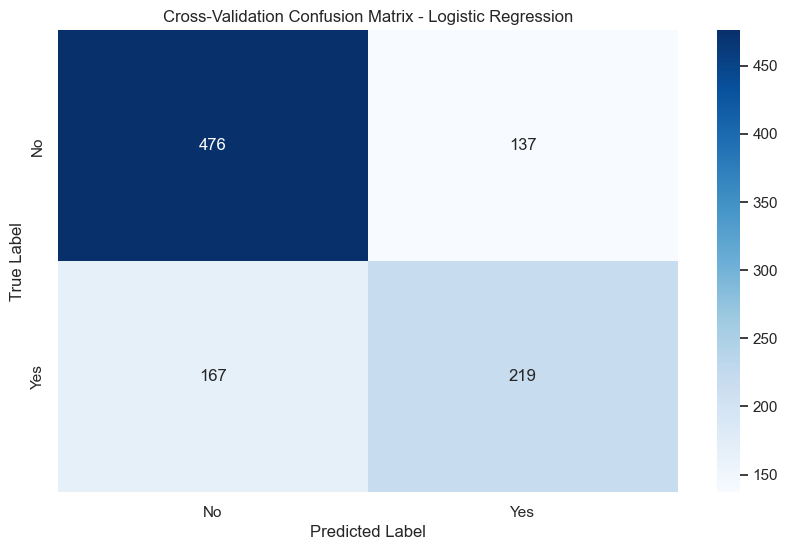

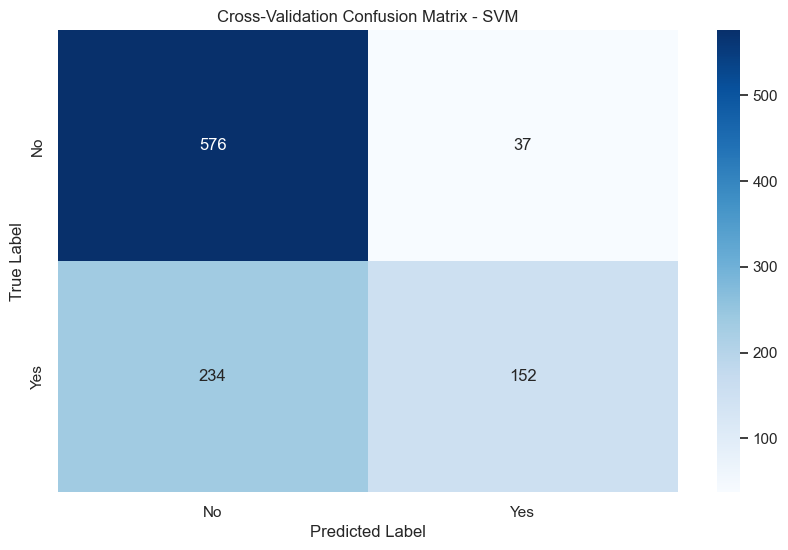

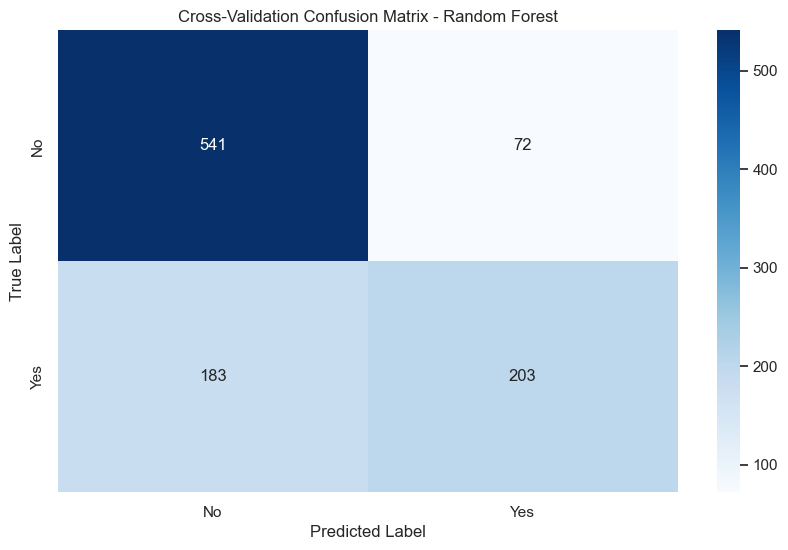

In [35]:
for name, model in best_models.items():
    y_pred_cv = cross_val_predict(model, X_train_poly_important, y_train,
                                  cv=stratified_kfold
                                  )
    plot_confusion_matrix(y_train, y_pred_cv,
                          f"Cross-Validation Confusion Matrix - {name}"
                          )

- Logistic Regression has a higher number of false negatives (167) than false positives (137), meaning it misses more actual positives than it wrongly classifies negatives as positives.
This suggests that the model struggles with recall, meaning it might be failing to identify some actual positive cases.

- SVM has very low false positives (37), but high false negatives (234). This indicates that SVM is biased toward the negative class, meaning it is conservative when predicting positives.
This could lead to high precision but low recall.

- Compared to SVM, Random Forest has a better balance between false positives and false negatives. It detects more true positives (203) than SVM (152) while maintaining relatively low false positives (72) compared to Logistic Regression (137). This suggests that Random Forest is the most balanced model among the three.

### 4.9 Final performance on the test set

Recreating the same interaction term features in the test set:

In [36]:
X_test_poly = create_poly_features(X_test, poly)
X_test_poly_important = X_test_poly[important_features]

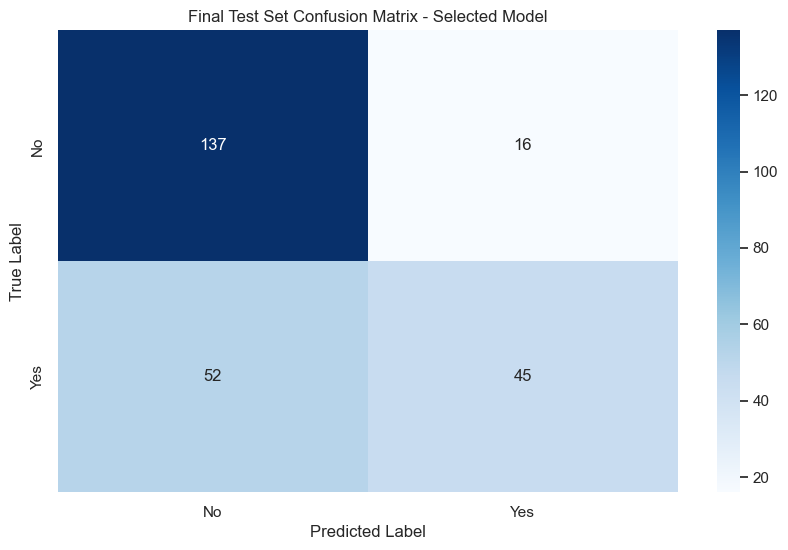

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       153
           1       0.74      0.46      0.57        97

    accuracy                           0.73       250
   macro avg       0.73      0.68      0.69       250
weighted avg       0.73      0.73      0.71       250

Final model PR AUC score on held-out test data: 0.6411


In [37]:
final_model = best_models["Random Forest"]
final_model.fit(X_train_poly_important, y_train)

y_pred_final = final_model.predict(X_test_poly_important)
y_proba_final = final_model.predict_proba(X_test_poly_important)[:, 1]

pr_auc_score_final = average_precision_score(y_test, y_proba_final)

plot_confusion_matrix(y_test, y_pred_final, "Final Test Set Confusion Matrix - Selected Model")
print(classification_report(y_test, y_pred_final))
print(f"Final model PR AUC score on held-out test data: {pr_auc_score_final:.4f}")

- The PR AUC score is **0.6411** on held-out test data, compared to **0.4027** using the random guessing model tried initially. This indicates that the current model has viable performance.
- The model incorrectly predicted 16 customers would buy insurance when they didn’t, indicated by high **precision** (for class 1) of **0.74**.
- The model only captured less than half customers that **would** buy insurance, indicated by **recall** (for class 1) of **0.46**.

### 4.10 Inspecting feature importance

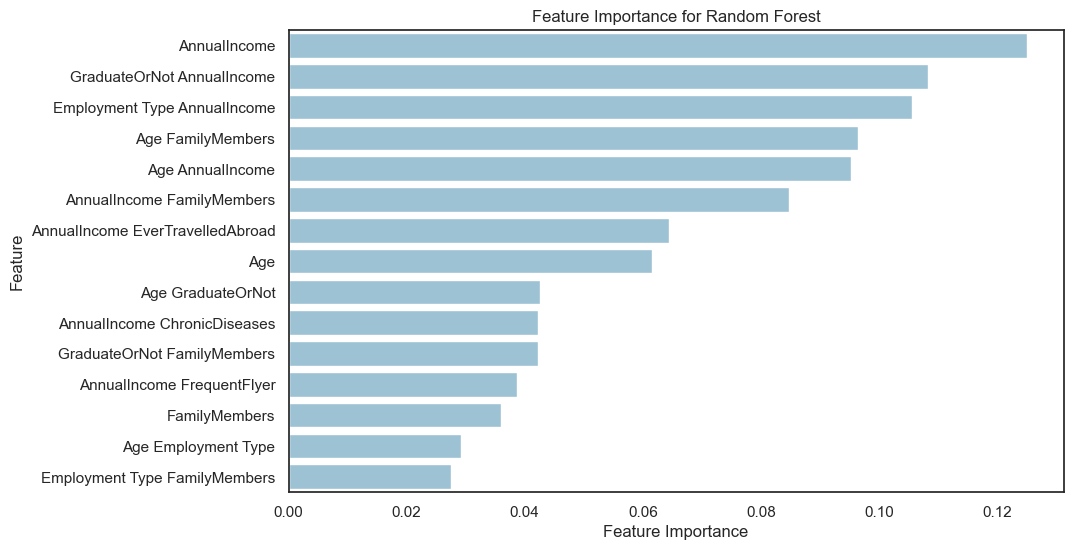

In [38]:
feature_importances = final_model[-1].feature_importances_
feature_names = X_train_poly_important.columns

plot_feature_importances(feature_names, feature_importances)

- **AnnualIncome** is the most important feature. This suggests that income plays a major role in predicting travel insurance purchase. Furthermore, interaction features involving **AnnualIncome** are highly ranked:
- **GraduateOrNot - AnnualIncome**, **Employment Type - AnnualIncome**, and **Age - AnnualIncome** show strong feature interactions. This reinforces the fact that adding polynomial interaction terms helped performance.
- **Age - FamilyMembers** and **AnnualIncome - FamilyMembers** are important as well. Older individuals with more family members may have different insurance purchasing behaviors. The interaction between income and age might indicate wealthier individuals are more likely to purchase insurance.

To summarize:
- **Annual Income** is a key driver of insurance purchasing decisions.
- Interactions between **Age**, **Income**, **Employment Type** and **Family Members** are important, suggesting that financial status and household size are key factors.
- Feature selection was effective in keeping only the most relevant interactions.

## 5. Results

The analysis revealed important insights regarding the likelihood of a customer purchasing travel insurance:

- **Income** and **Age** were among the most influential factors in predicting travel insurance purchase. A **t-test** confirmed that the mean income of those who purchased insurance (*~1.068m*) was significantly higher than those who did not (*~850k*) with a **p-value** < 0.05.
- **Ever Travelled Abroad** feature showed a significantly higher insurance purchase rate. A **proportions z-test** showed that with a **p-value** < 0.05, people that have previously travelled abroad have a significantly higher chance *(with a 95% CI of **30.25% - 43.18%**)* of buying insurance 
- **Family Size** had a noticable influence as well, indicating that families with more members may have different insurance purchasing behaviors.
- **Random Forest** outperformed other models with a **PR AUC** of **0.6411** (on final test data), suggesting it best captures the complexity of the dataset.
- **SVM** and **Logistic Regression** provided comparable results using train data.

### Answers to Goals and Stakeholder Needs

- **For Insurance Companies**: The analysis confirms that income and past travel experience are key indicators of insurance purchase likelihood. By focusing on high-income individuals and those who have traveled abroad, insurers can optimize their targeting strategy to maximize conversions.
- **For Marketing Teams**: Since people who traveled abroad before show a statistically significant higher purchase rate, ad campaigns can focus on this to reduce wasted spending. Additionally, targeting individuals with higher incomes can increase ROI, as they are more likely to afford and purchase insurance.
- **For Business Analysts**: The Random Forest model provides the most reliable method for assessing purchase likelihood. This model can help refine risk assessment by identifying customers who are more likely to buy, as well as rarely misclassifying false positives, allowing for better pricing strategies and policy recommendations.

## 6. Future improvements

- Investigate feature importance in SVM & Logistic Regression.
- Consider ensemble methods (combining Logistic Regression & Random Forest).
- Try more models after feature engineering.
- Check class imbalance handling (resampling, SMOTE).